<a href="https://colab.research.google.com/github/howsam/Building-a-ChatGPT-like-Model-from-Scratch/blob/main/Build_GPT-2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  <font color='#FFE15D'><b>💎 Build GPT-2 </b></font>

# 🔴 **Environment Setup**

## 🟠 Change the font size of the output cells

In [ ]:
print('Salam Howsam!')

Salam Howsam!


In [ ]:
from IPython.display import HTML
shell = get_ipython()

def adjust_font_size():
  display(HTML('''<style>
    body {
      font-size: 24px;
    }
  '''))

if adjust_font_size not in shell.events.callbacks['pre_execute']:
  shell.events.register('pre_execute', adjust_font_size)

In [ ]:
print('Salam Howsam!')

Salam Howsam!


## 🟠 `pip`

In [ ]:
!pip install datasets

# 🔴 **Import**

In [ ]:
import time
from dataclasses import dataclass

from datasets import load_dataset
from tokenizers import Tokenizer

import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.nn import functional as F

# 🔴 **Utils**

In [ ]:
def prepare_data(tokens, seq_len):
    # Trim tokens so that total length is divisible by seq_len
    n_tokens = (tokens.shape[0] // seq_len) * seq_len
    tokens = tokens[:n_tokens]

    # Reshape to 2D tensor
    return tokens.view(-1, seq_len)


In [ ]:
def num_trainable_params(model):
  nums = sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6
  return nums

In [ ]:
def calculate_time(model, x, num_runs=10):
    torch.cuda.synchronize()
    start = time.time()
    for _ in range(num_runs):
        model(*x)
    torch.cuda.synchronize()
    return (time.time() - start) / num_runs

# 🔴 **Init**

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# 🔴 **Dataset**

In [ ]:
dataset = load_dataset("roneneldan/TinyStories")
dataset

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 2119719
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 21990
    })
})

In [ ]:
tokenizer = Tokenizer.from_file("bpe-tokenizer_tinystories.json")
tokenizer

In [ ]:
# Load tokens from pytorch file
train_token_ids = torch.load('tokenized-train-samples_vocab-10k.pt')
valid_token_ids = torch.load('tokenized-valid-samples_vocab-10k.pt')

print("📊 Number of Tokens")
print(f"🔹 Train: {len(train_token_ids):,} tokens")
print(f"🔹 Valid: {len(valid_token_ids):,} tokens")

📊 Number of Tokens
🔹 Train: 464,965,814 tokens
🔹 Valid: 4,673,588 tokens


In [ ]:
class TinyStoriesDataset(Dataset):

    def __init__(self, data, seq_len):
        self.seq_len = seq_len
        self.data = prepare_data(data, seq_len+1)

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        sample = self.data[idx]
        return sample[:-1], sample[1:]#.long()

In [ ]:
seq_len = 128

train_set = TinyStoriesDataset(train_token_ids, seq_len)
valid_set = TinyStoriesDataset(valid_token_ids, seq_len)

print(f"📊 Number of Samples")
print(f"🔹 Train: {len(train_set):,} samples")
print(f"🔹 Valid: {len(valid_set):,} samples")

📊 Number of Samples
🔹 Train: 3,604,386 samples
🔹 Valid: 36,229 samples


In [ ]:
x, y = next(iter(train_set))

print(f"📊 Sample Shapes")
print(f"🔹 Input: {x.shape}")
print(f"🔹 Target: {y.shape}")

📊 Sample Shapes
🔹 Input: torch.Size([128])
🔹 Target: torch.Size([128])


In [ ]:
torch.manual_seed(1337)
batch_size = 64

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, pin_memory=True)#, num_workers=4)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False, pin_memory=True)#, num_workers=4)

print(f"📊 Number of Batches")
print(f"🔹 Train: {len(train_loader):,} batches")
print(f"🔹 Valid: {len(valid_loader):,} batches")

📊 Number of Batches
🔹 Train: 56,319 batches
🔹 Valid: 567 batches


In [ ]:
x_batch, y_batch = next(iter(train_loader))

print(f"📊 Batch Shapes")
print(f"🔹 Input: {x_batch.shape}")
print(f"🔹 Target: {y_batch.shape}")

📊 Batch Shapes
🔹 Input: torch.Size([64, 128])
🔹 Target: torch.Size([64, 128])


# 🔴 **Model**

## 🟠 Embedding

In [ ]:
wte = nn.Embedding(tokenizer.get_vocab_size(), 100)
wte(torch.tensor([1, 2, 100])).shape

torch.Size([3, 100])

In [ ]:
wpe = nn.Embedding(seq_len, 100)
wpe(torch.tensor([1, 2, 100])).shape

torch.Size([3, 100])

In [ ]:
x = wte(x_batch) + wpe(torch.arange(x_batch.shape[1]))
x.shape

torch.Size([64, 128, 100])

## 🟠 Scaled Dot-Product Attention

In [ ]:
q = k = v = x
print(q.shape)

mask = torch.tril(torch.ones(seq_len, seq_len))

scores = q @ k.transpose(-2, -1) / (k.shape[-1]**0.5)
scores.masked_fill_(mask ==0, float(-torch.inf))
scores = scores.softmax(dim=-1)
print(scores.shape)

z = scores @ v
z.shape

torch.Size([64, 128, 100])
torch.Size([64, 128, 128])


torch.Size([64, 128, 100])

In [ ]:
# scores = torch.randn(3, 5, 5)
# mask = torch.tril(torch.ones(5, 5))
# scores.masked_fill_(mask ==0, float(-torch.inf))
# scores = scores.softmax(dim=-1)
# scores

In [ ]:
def scaled_dot_product_attention(q, k, v):
    mask = torch.tril(torch.ones(q.shape[-2], q.shape[-2])).to(device)
    scores = q @ k.transpose(-2, -1) / (k.shape[-1]**0.5)
    scores.masked_fill_(mask==0, float(-torch.inf))
    scores = scores.softmax(dim=-1)
    z = scores @ v
    return z

In [ ]:
scaled_dot_product_attention(x.to(device), x.to(device), x.to(device)).shape

torch.Size([64, 128, 100])

In [ ]:
q = torch.randn((128, 1024, 768), device=device)
k = torch.randn((128, 1024, 768), device=device)
v = torch.randn((128, 1024, 768), device=device)
q.shape

torch.Size([128, 1024, 768])

In [ ]:
scaled_dot_product_attention(q, k, v).shape

torch.Size([128, 1024, 768])

In [ ]:
calculate_time(scaled_dot_product_attention, (q, k, v), num_runs=20)

0.13929617404937744

In [ ]:
F.scaled_dot_product_attention(q, k, v, is_causal=True).shape

C:\Users\Howsam\AppData\Local\Temp\ipykernel_2732\251168821.py:1: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  F.scaled_dot_product_attention(q, k, v, is_causal=True).shape


torch.Size([128, 1024, 768])

In [ ]:
torch.abs(scaled_dot_product_attention(q, k, v) - F.scaled_dot_product_attention(q, k, v, is_causal=True)).max()

tensor(6.6757e-06, device='cuda:0')

In [ ]:
calculate_time(F.scaled_dot_product_attention, (q, k, v), num_runs=20)

0.12824971675872804

## 🟠 Multi Head Attention

In [ ]:
# class MultiHeadAttention(nn.Module):

#     def __init__(self):
#         super().__init__()
#         self.fc1 = nn.Linear(100, 1000)
#         self.fc2 = nn.Linear(1000, 100)
#         self.fc3 = nn.Linear(1000, 100)

#     def forward(self, x):
#         y = F.relu(self.fc1(x))
#         y1 = self.fc2(y)
#         y2 = self.fc3(y)
#         return F.relu(torch.concat([y1, y2], dim=-1))

In [ ]:
# mha = MultiHeadAttention()
# num_trainable_params(mha)
# mha.forward(torch.rand(10, 100)).shape

In [ ]:
class GPTConfig:
    n_embd: int = 100
    n_head: int = 5

config = GPTConfig()
config.n_embd

100

In [ ]:
class MultiHeadAttention(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.n_embd = config.n_embd
        self.n_head = config.n_head
        self.head_size = self.n_embd // self.n_head

        self.qkv_proj = nn.Linear(self.n_embd, 3*self.n_embd, bias=False)

        self.c_proj = nn.Linear(self.n_embd, self.n_embd, bias=False)
        self.c_proj.residual = True

    def forward(self, x):
        B, T, C = x.shape
        q, k, v = self.qkv_proj(x).view(B, T, 3*self.n_head, self.head_size).transpose(1, 2).chunk(3, dim=-3)

        y = F.scaled_dot_product_attention(q, k, v, is_causal=True)

        y = y.transpose(1, 2).contiguous().view(B, T, C)

        y = self.c_proj(y)
        return y

In [ ]:
mha = MultiHeadAttention(config)
mha(x).shape

torch.Size([64, 128, 100])

In [ ]:
xx = torch.arange(24).view(2, 2, 3, 2)
print(xx)
xx.reshape(2, 3, 4)

tensor([[[[ 0,  1],
          [ 2,  3],
          [ 4,  5]],

         [[ 6,  7],
          [ 8,  9],
          [10, 11]]],


        [[[12, 13],
          [14, 15],
          [16, 17]],

         [[18, 19],
          [20, 21],
          [22, 23]]]])


tensor([[[ 0,  1,  2,  3],
         [ 4,  5,  6,  7],
         [ 8,  9, 10, 11]],

        [[12, 13, 14, 15],
         [16, 17, 18, 19],
         [20, 21, 22, 23]]])

In [ ]:
calculate_time(mha.to(device), (x.to(device),), num_runs=20)

0.0009491205215454102

## 🟠 Feed Forward (MLP)

In [ ]:
class GPTConfig:
    n_embd: int = 100
    n_head: int = 5
    f_expnd: float = 4

config = GPTConfig()
config.n_embd

100

In [ ]:
class FeedForward(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.n_embd = config.n_embd
        self.f_expnd = config.f_expnd

        self.up_proj = nn.Linear(self.n_embd, int(self.f_expnd*self.n_embd), bias=False)
        self.down_proj = nn.Linear(int(self.f_expnd*self.n_embd), self.n_embd, bias=False)
        self.down_proj.residual = True

    def forward(self, x):
        return self.down_proj(F.gelu(self.up_proj(x)))

In [ ]:
mlp = FeedForward(config)
mlp(x).shape

torch.Size([64, 128, 100])

In [ ]:
num_trainable_params(mlp)*1000

80.0

In [ ]:
calculate_time(mlp, (x, ), num_runs=20)

0.013211965560913086

## 🟠 Decoder Block

In [ ]:
class DecoderBlock(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.n_embd = config.n_embd

        self.ln1 = nn.LayerNorm(config.n_embd)
        self.mha = MultiHeadAttention(config)

        self.ln2 = nn.LayerNorm(config.n_embd)
        self.mlp = FeedForward(config)

    def forward(self, x):
        x = x + self.mha(self.ln1(x))
        x = x + self.mlp(self.ln2(x))
        return x

In [ ]:
decoder = DecoderBlock(config)
decoder(x).shape

torch.Size([64, 128, 100])

In [ ]:
num_trainable_params(decoder) * 1e3

120.39999999999999

In [ ]:
calculate_time(decoder, (x, ), num_runs=20) * 1e3

52.333009243011475

## 🟠 GPT

In [ ]:
class GPTConfig:
    vocab_size: int = 10_000
    seq_len: int = 128
    n_layer: int = 12
    n_embd: int = 100
    n_head: int = 5
    f_expnd: float = 4


config = GPTConfig()
config.n_embd

100

In [ ]:
class GPT(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.config = config
        self.wte = nn.Embedding(config.vocab_size, config.n_embd)
        self.wpe = nn.Embedding(config.seq_len, config.n_embd)
        # self.decoders = nn.Sequential(*[DecoderBlock(config) for _ in range(config.n_layer)])
        self.decoders = nn.ModuleList([DecoderBlock(config) for _ in range(config.n_layer)])
        self.lnf = nn.LayerNorm(config.n_embd)
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

        self.lm_head.weight = self.wte.weight
        # self.lm_head.weight.data.uniform_(-1/self.lm_head.in_features**0.5, 1/self.lm_head.in_features**0.5)
        # nn.init.uniform_(self.lm_head.weight, -1/self.lm_head.in_features**0.5, 1/self.lm_head.in_features**0.5)

        self.apply(self._init_weights)

    def _init_weights(self, module):
        std = 0.02
        if isinstance(module, nn.Linear):
            if hasattr(module, 'residual'):
                std *= (2*self.config.n_layer)**-0.5
            nn.init.normal_(module.weight, mean=0.0, std=std)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            nn.init.normal_(module.weight, mean=0.0, std=std)

    def forward(self, idx):
        B, T = idx.shape

        x = self.wte(idx) + self.wpe(torch.arange(T, device=device))

        # x = self.decoders(x)
        for decoder in self.decoders:
            x = decoder(x)

        x = self.lnf(x)
        logits = self.lm_head(x)
        return logits

In [ ]:
model = GPT(config).to(device)
model(x_batch.to(device)).shape

torch.Size([64, 128, 10000])

In [ ]:
num_trainable_params(model), num_trainable_params(model.decoders), num_trainable_params(model.lm_head)

(2.4578, 1.4448, 1.0)

In [ ]:
calculate_time(model, (x_batch.to(device),), num_runs=100) * 1e3

13.62372875213623

## 🟠 Initialization

In [ ]:
model = GPT(
    GPTConfig(
        seq_len=256, vocab_size=10_000, n_layer=4, n_embd=256, n_head=4
        )).to(device)

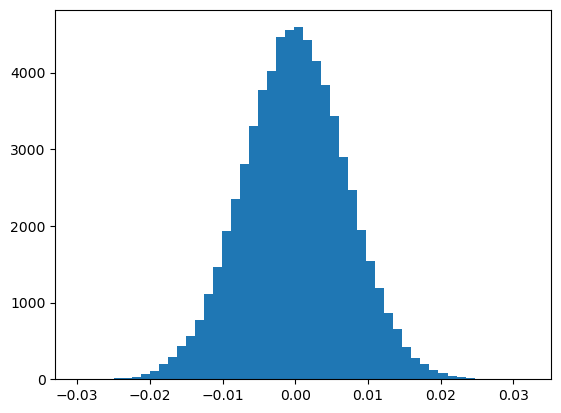

In [ ]:
plt.hist(model.decoders[0].mha.c_proj.weight.flatten().detach().cpu(), bins=50);

In [ ]:
0.02 * (2*4)**-0.5 * 3

0.021213203435596427

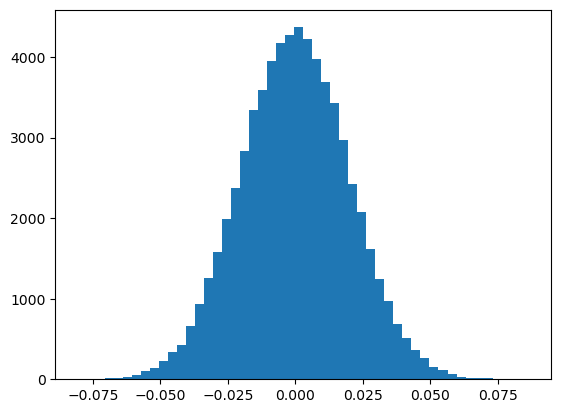

In [ ]:
plt.hist(model.wpe.weight.flatten()[:100_000].detach().cpu(), bins=50);

In [ ]:
plt.hist(model)

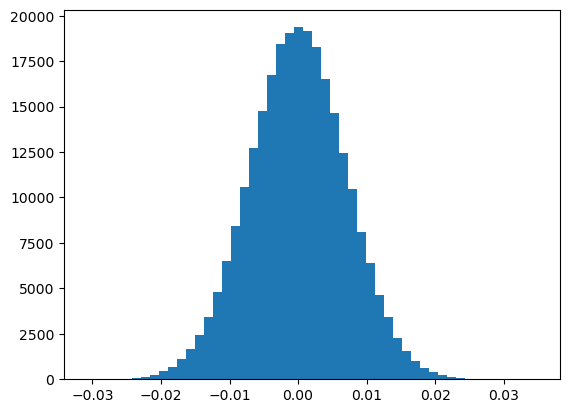

In [ ]:
plt.hist(model.decoders[2].mlp.down_proj.weight.flatten().detach().cpu(), bins=50);

# 🔴 **Config**

In [ ]:
@dataclass
class GPTConfig:
    vocab_size: int = 50257 # number of tokens
    seq_len: int = 1024 # max sequence length
    n_layer: int = 12 # number of layers
    n_head: int = 12 # number of heads
    n_embd: int = 768 # embedding dimension
    f_expnd: int = 4 # expansion factor in mlp

In [ ]:
model = GPT(GPTConfig()).to(device)
model

GPT(
  (wte): Embedding(50257, 768)
  (wpe): Embedding(1024, 768)
  (decoders): ModuleList(
    (0-11): 12 x DecoderBlock(
      (ln1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mha): MultiHeadAttention(
        (qkv_proj): Linear(in_features=768, out_features=2304, bias=False)
        (c_proj): Linear(in_features=768, out_features=768, bias=False)
      )
      (ln2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): FeedForward(
        (up_proj): Linear(in_features=768, out_features=3072, bias=False)
        (down_proj): Linear(in_features=3072, out_features=768, bias=False)
      )
    )
  )
  (lnf): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [ ]:
num_trainable_params(model)

print(f"🔹 Trainable parameters: {num_trainable_params(model):,}")

🔹 Trainable parameters: 162.95424


In [ ]:
config = GPTConfig(vocab_size=10_000, seq_len=128)
config

GPTConfig(vocab_size=10000, seq_len=128, n_layer=12, n_head=12, n_embd=768, f_expnd=4)

In [ ]:
model = GPT(
    GPTConfig(
        seq_len=256, vocab_size=10_000, n_layer=4, n_embd=256, n_head=4
        )).to(device)

print(f"🔹 Trainable parameters: {num_trainable_params(model):,}")
print(model)

🔹 Trainable parameters: 5.775872
GPT(
  (wte): Embedding(10000, 256)
  (wpe): Embedding(256, 256)
  (decoders): ModuleList(
    (0-3): 4 x DecoderBlock(
      (ln1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (mha): MultiHeadAttention(
        (qkv_proj): Linear(in_features=256, out_features=768, bias=False)
        (c_proj): Linear(in_features=256, out_features=256, bias=False)
      )
      (ln2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (mlp): FeedForward(
        (up_proj): Linear(in_features=256, out_features=1024, bias=False)
        (down_proj): Linear(in_features=1024, out_features=256, bias=False)
      )
    )
  )
  (lnf): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (lm_head): Linear(in_features=256, out_features=10000, bias=False)
)


In [ ]:
# Embedding layers
wte_params = num_trainable_params(model.wte)  # Word Token Embedding
wpe_params = num_trainable_params(model.wpe)  # Position Embedding

# Optional: Classifier head
lm_head_params = num_trainable_params(model.lm_head)

# Total trainable parameters without weight tying
total_params_without_tying = num_trainable_params(model)

# Total trainable parameters with weight tying
total_params_with_tying = total_params_without_tying - wte_params

# Core model params (excluding embeddings and head)
core_params = total_params_without_tying - wte_params - wpe_params - lm_head_params

# Print results
print(f"🔹 Total trainable parameters without weight tying: {total_params_without_tying:,}")
print(f"🔹 Total trainable parameters with weight tying: {total_params_with_tying:,}")
print(f"🔹 Embedding parameters (WTE + WPE): {wte_params + wpe_params:,}")
print(f"🔹  └─ WTE: {wte_params:,}")
print(f"🔹  └─ WPE: {wpe_params:,}")
print(f"🔹 Classifier head parameters: {lm_head_params:,}")
print(f"🔹 Transformer core (excluding embeddings & head): {core_params:,}")

🔹 Total trainable parameters without weight tying: 5.775872
🔹 Total trainable parameters with weight tying: 3.2158719999999996
🔹 Embedding parameters (WTE + WPE): 2.625536
🔹  └─ WTE: 2.56
🔹  └─ WPE: 0.065536
🔹 Classifier head parameters: 2.56
🔹 Transformer core (excluding embeddings & head): 0.5903359999999997


# 🔴 **Usage**

In [ ]:
x_batch.shape, y_batch.shape

(torch.Size([64, 128]), torch.Size([64, 128]))

In [ ]:
model

GPT(
  (wte): Embedding(10000, 256)
  (wpe): Embedding(256, 256)
  (decoders): ModuleList(
    (0-3): 4 x DecoderBlock(
      (ln1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (mha): MultiHeadAttention(
        (qkv_proj): Linear(in_features=256, out_features=768, bias=False)
        (c_proj): Linear(in_features=256, out_features=256, bias=False)
      )
      (ln2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (mlp): FeedForward(
        (up_proj): Linear(in_features=256, out_features=1024, bias=False)
        (down_proj): Linear(in_features=1024, out_features=256, bias=False)
      )
    )
  )
  (lnf): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (lm_head): Linear(in_features=256, out_features=10000, bias=False)
)

## 🟠 Train

In [ ]:
# step 1: x_batch -> model
logits = model(x_batch.to(device))
print(logits.shape)
print(logits[0, 0])
logits[0, 0].softmax(dim=0)

torch.Size([64, 128, 10000])
tensor([ -8.5584,  36.8211, -11.6015,  ...,   1.5867,   4.4906, -21.2335],
       device='cuda:0', grad_fn=<SelectBackward0>)


tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)

In [ ]:
# step 2: (logits, y_batch) -> loss (cross entropy)

print(logits.view(-1, logits.shape[-1]).shape)
print(y_batch.flatten().shape, y_batch.dtype)

loss = F.cross_entropy(logits.view(-1, logits.shape[-1]), y_batch.flatten().to(device).long())
loss

torch.Size([8192, 10000])
torch.Size([8192]) torch.int32


tensor(171.7543, device='cuda:0', grad_fn=<NllLossBackward0>)

In [ ]:
# step 3: backward

loss.backward()

model.decoders[0].mha.qkv_proj.weight.grad

tensor([[-5.7972e-04, -1.7659e-05, -1.3474e-03,  ...,  1.1278e-03,
         -1.6872e-04, -6.4572e-04],
        [ 7.8478e-05,  2.8710e-03,  3.3990e-04,  ..., -7.0286e-04,
         -4.7557e-04,  2.8578e-04],
        [ 1.1564e-03,  8.2433e-04,  5.5188e-04,  ..., -1.3572e-03,
         -1.0208e-03, -9.2998e-04],
        ...,
        [-1.5034e-03,  1.1080e-03,  1.0702e-03,  ...,  4.8123e-03,
          4.4442e-03,  7.8170e-04],
        [-9.9288e-03,  2.3240e-03,  3.0702e-03,  ...,  7.4174e-03,
          1.6948e-02,  2.9948e-03],
        [-3.1107e-03,  8.3819e-04, -9.2872e-04,  ..., -2.0451e-04,
         -5.4744e-03, -1.1824e-03]], device='cuda:0')

In [ ]:
# step 4: optimizer

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
optimizer.step()
optimizer.zero_grad()

model.decoders[0].mha.qkv_proj.weight.grad

In [ ]:
logits = model(x_batch.to(device))
loss = F.cross_entropy(logits.view(-1, logits.shape[-1]), y_batch.flatten().to(device).long())
loss

tensor(142.2846, device='cuda:0', grad_fn=<NllLossBackward0>)

In [ ]:
model.train()

for iter, (x_batch, y_batch) in enumerate(train_loader):
    logits = model(x_batch.to(device))
    loss = F.cross_entropy(logits.view(-1, logits.shape[-1]), y_batch.flatten().to(device).long())
    print(loss.item())
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    if iter > 100:
        break

In [ ]:
torch.cuda.empty_cache()

In [ ]:
-torch.log(torch.tensor(0.5)) # binary classification
-torch.log(torch.tensor(1/10)) # 10 class
-torch.log(torch.tensor(1/10_000)) # 10_000 class

tensor(9.2103)

## 🟠 Loss!

In [ ]:
model = GPT(
    GPTConfig(
        seq_len=256, vocab_size=10_000, n_layer=4, n_embd=256, n_head=4
        )).to(device)

In [ ]:
logits = model(x_batch.to(device))

In [ ]:
output = logits[0, 0]
print(output.min(), output.max())

scores = output.softmax(dim=0)
print(scores.min(), scores.max()) # 1/10_000

tensor(-63.6487, device='cuda:0', grad_fn=<MinBackward1>) tensor(166.6140, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0., device='cuda:0', grad_fn=<MinBackward1>) tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)


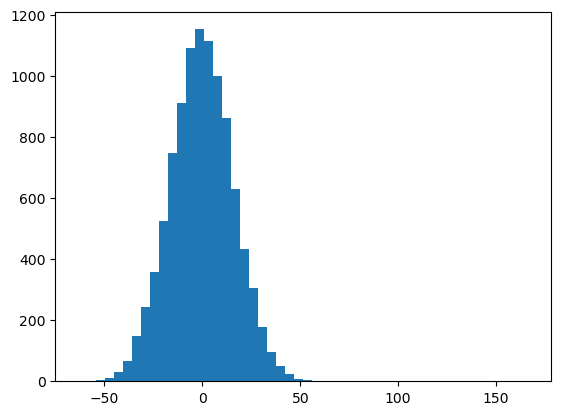

In [ ]:
plt.hist(output.flatten()[:100_000].detach().cpu(), bins=50);

### With `nn.init.uniform_()`

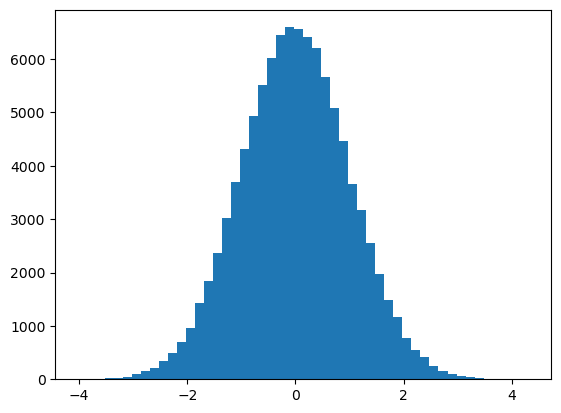

In [ ]:
plt.hist(model.lm_head.weight.flatten()[:100_000].detach().cpu(), bins=50);

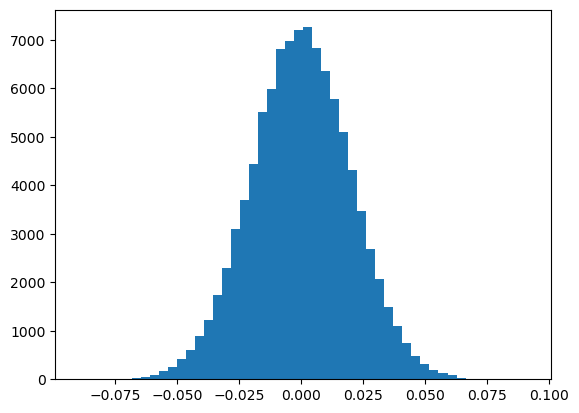

In [ ]:
plt.hist(model.lm_head.weight.flatten()[:100_000].detach().cpu(), bins=50);

In [ ]:
1/256**0.5

0.0625

In [ ]:
output = logits[0, 0]
print(output.min(), output.max())

scores = output.softmax(dim=0)
print(scores.min(), scores.max()) # 1/10_000

tensor(-2.4061, device='cuda:0', grad_fn=<MinBackward1>) tensor(2.0798, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(7.7169e-06, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0007, device='cuda:0', grad_fn=<MaxBackward1>)


In [ ]:
print(F.cross_entropy(output, y_batch[0, 0].to(device).long()))
F.cross_entropy(logits.view(-1, logits.shape[-1]), y_batch.flatten().to(device).long())

tensor(9.2536, device='cuda:0', grad_fn=<NllLossBackward0>)


tensor(9.4062, device='cuda:0', grad_fn=<NllLossBackward0>)

## 🟠 Evaluate

In [ ]:
model.eval()

# with torch.no_grad():
with torch.inference_mode():
    for iter, (x_batch, y_batch) in enumerate(valid_loader):
        logits = model(x_batch.to(device))
        loss = F.cross_entropy(logits.view(-1, logits.shape[-1]), y_batch.flatten().to(device).long())
        print(loss.item())
        if iter > 10:
            break

26.615428924560547
27.936418533325195
27.851327896118164
27.53526496887207
26.53456687927246
27.032155990600586
27.162120819091797
27.79241180419922
28.003631591796875
27.722562789916992
27.953567504882812
26.673913955688477


## 🟠 Generate

In [ ]:
torch.cuda.empty_cache()

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

In [ ]:
model.train()

for iter, (x_batch, y_batch) in enumerate(train_loader):
    logits = model(x_batch.to(device))
    loss = F.cross_entropy(logits.view(-1, logits.shape[-1]), y_batch.flatten().to(device).long())
    print(loss.item())
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    if iter > 100:
        break

3.658418655395508
3.6881611347198486
3.650334358215332
3.6026995182037354
3.5193774700164795
3.6633810997009277
3.6715610027313232
3.437781810760498
3.5418334007263184
3.604189872741699
3.610496759414673
3.6069014072418213
3.611006259918213
3.555436849594116
3.534325122833252
3.6286532878875732
3.6450140476226807
3.4932892322540283
3.4747843742370605
3.617899179458618
3.447073221206665
3.499760150909424
3.451608419418335
3.675903081893921
3.428499937057495
3.5338501930236816
3.5779263973236084
3.5961499214172363
3.50474214553833
3.5453033447265625
3.434633493423462
3.399848461151123
3.4938864707946777
3.4540774822235107
3.4897844791412354
3.518000364303589
3.482717752456665
3.4298133850097656
3.4764933586120605
3.519031524658203
3.4877750873565674
3.4479498863220215
3.5835278034210205
3.5960822105407715
3.4684722423553467
3.5699689388275146
3.4583659172058105
3.4804608821868896
3.394000768661499
3.464993476867676
3.4857468605041504
3.54040265083313
3.560106039047241
3.3968617916107178


In [ ]:
max_seq_len = 128

prompt = 'In last night'
tokens = tokenizer.encode(prompt).ids
tokens = torch.tensor(tokens, dtype=torch.int, device=device).unsqueeze(0)
print(tokens)

model.eval()
with torch.inference_mode():
    for i in range(max_seq_len):
        logits = model(tokens)
        scores = logits[0, [-1]].softmax(dim=-1)
        idx = scores.argmax(keepdims=True)
        tokens = torch.cat((tokens, idx), dim=-1)

tokenizer.decode(tokens[0].tolist())

tensor([[   1, 2201, 2220, 1076]], device='cuda:0', dtype=torch.int32)


'In last night, the little girl was walking in the park. She was very excited to go to the park.\n\nOne day, she saw a big, a big, a big, and a big, and a big, and a big, and a big, and a big bird. The bird was very happy.\n\nThe bird was so happy and happy.Once upon a time, there was a little girl named Lily. She loved to play with her toys and play with her friends. One day, she saw a big, a big dog named Lily. She was very happy.\n\n"I\'m sorry, Lily,'